## The importance of a multi-scale approach
Many datasets exhibit information on different scales, and it is difficult to know a-priori on which scale the relevant information is going to be. In addition, different combinations of (distance metric + scale) will be sensitive to different aspects of the data. Therefore, the multi-scale approach of the Sequencer is critical to truly uncover the leading trend in the data. The first part of the notebook addresses these issues by examining a dataset where a sequence-related information is present on both small scales and large scales. In this notebook I use the intermediate axis ratios obtained for different chunks of the data to illustrate where the sequence-related information is. <br>

I will use model stellar spectra from the MILES library (http://miles.iac.es/pages/stellar-libraries/miles-library.php). The main advantage of this dataset is that stellar spectra exhibit information on many scales, both small and large scales. Although the spectra appear extremely complex at first sight, they form a more-or-less one-dimensional sequence that is tied to the stellar temperature/mass. Therefore, these spectra are an ideal dataset to illustrate the two points discussed above.

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [5]:
#!conda install numpy scipy networkx matplotlib astropy
#!pip install TheSequencer

In [6]:
# imports
%matplotlib inline

import glob

import numpy
import matplotlib.pyplot as plt
from astropy.io import fits

import sequencer

## Load the MILES library
I will start by loading the stellar spectra and visualizing them.

In [7]:
spectra_path_list = glob.glob("data_for_examples/MILES_library/*")

spectra_list = []
for i, spectrum_path in enumerate(spectra_path_list):
    # load the spectrum from the .fits file
    h = fits.open(spectrum_path)
    spectrum = h[0].data
    # normalize the spectrum
    norm_spectrum = spectrum / numpy.median(spectrum)
    
    spectra_list.append(norm_spectrum)
    
print("number of stellar spectra: %s" % len(spectra_list))
print("length of each spectrum: %s" % len(spectra_list[0]))

number of stellar spectra: 53
length of each spectrum: 4300


Visualize a subset of these spectra using traditional line plot. Then, visualize the entire dataset by considering it as a 2D array using pcolormesh.

Text(0, 0.5, 'object index')

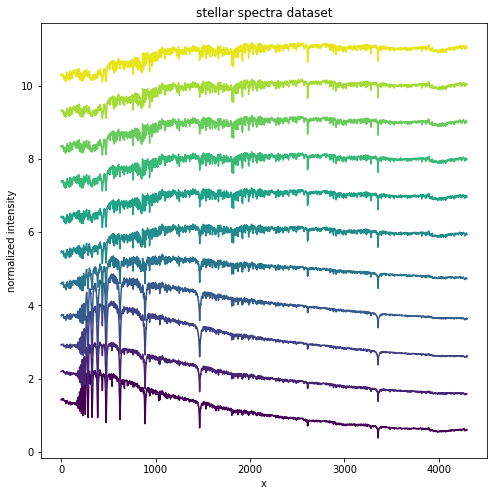

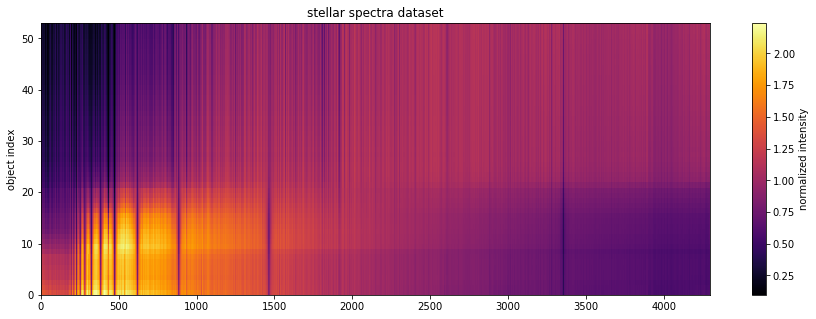

In [37]:
import matplotlib as mpl
import matplotlib.cm as cm


########################## first ploting option ################################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(1, figsize=(8, 8))
plt.title("stellar spectra dataset")
for i in range(0, len(spectra_list), 5):
    plt.plot(spectra_list[i] + i*0.2, color=m.to_rgba(i))
plt.xlabel("x")
plt.ylabel("normalized intensity")

########################## second ploting option ################################################

plt.figure(2, figsize=(15, 5))
plt.title("stellar spectra dataset")
plt.pcolormesh(spectra_list, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

Text(0, 0.5, 'object index')

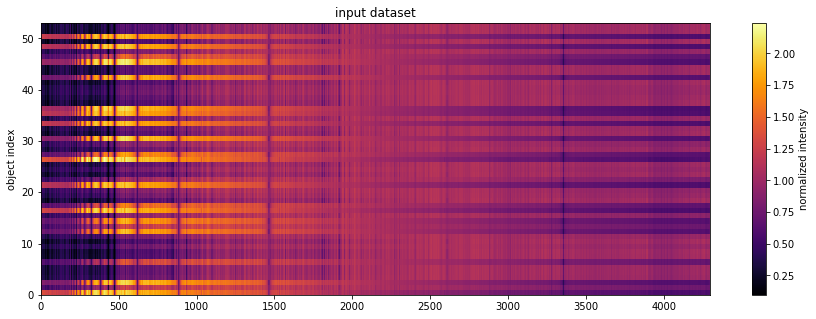

In [14]:
# shuffle the dataset and produce the data that will serve as the input to the sequencer

grid = numpy.arange(0, len(spectra_list[0]), 1)
indices = numpy.arange(len(spectra_list))
numpy.random.shuffle(indices)
spectra_list = numpy.array(spectra_list)
objects_list_shuffled = spectra_list[indices, :]

plt.figure(1, figsize=(15, 5))
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

## The importance of a multi-scale approach 
In this part of the notebook I will apply the Sequencer to the dataset using several scales, some of which correspond to small scales and others to large scales. I will then extract the intermediate axis ratios obtained for the different scales. In particular, I wish to examine which parts of the data contribute more to the final sequence. <br>

For a given scale, the Sequencer divides each object in the dataset into chunks (parts), and estimates pair-wise distances between the chunks of objects. It then constructs an MST and calculates an axis ratio of each chunk separately. After that, it averages the distance matrices per chunk, weighted by the resulting axis ratio. The result is a weighted distance matrix that incorporates the information from all the different chunks. To illustrate the importance of the multi-scale approach, I will extract the intermediate axis ratios obtained for the different chunks. These axis ratios indicate where the sequence-related information is. 

To reduce the computation time, I will consider only the Euclidean distance and will set the scale list manually.

In [15]:
# apply the Sequencer to the shuffled dataset
estimator_list = ['L2']
scale_list = [[1, 2, 5, 10, 20]]
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list, scale_list)
output_path = "sequencer_output_directory"
final_axis_ratio, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.05316305160522461 seconds
calculating the distance matrices for estimator: L2, scale: 2
finished calculating this distance matrix list, it took: 0.03700709342956543 seconds
calculating the distance matrices for estimator: L2, scale: 5
finished calculating this distance matrix list, it took: 0.0774068832397461 seconds
calculating the distance matrices for estimator: L2, scale: 10
finished calculating this distance matrix list, it took: 0.1476731300354004 seconds
calculating the distance matrices for estimator: L2, scale: 20
finished calculating this distance matrix list, it took: 0.3228611946105957 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 5
in estimator: L2, scale: 1

../code/sequencer.py:937: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


resulting axis ratio:  53.0
intermediate axis ratios for the different metrics and scales:
metric=L2, scale=1, axis ratio: 53.0
metric=L2, scale=2, axis ratio: 53.0
metric=L2, scale=5, axis ratio: 53.0
metric=L2, scale=10, axis ratio: 53.0
metric=L2, scale=20, axis ratio: 53.0


Text(0, 0.5, 'object index')

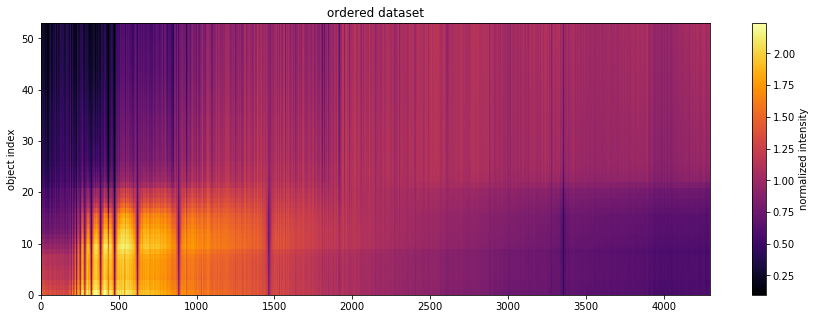

In [17]:
# print the resulting axis ratio
print("resulting axis ratio: ", final_axis_ratio)

# print the intermediate axis ratios for different metrics + scales
estimator_list, scale_list, axis_ratio_list = seq.return_axis_ratio_of_weighted_products_all_metrics_and_scales()

print("intermediate axis ratios for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, axis ratio: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(axis_ratio_list[i], 2)))
    
# plot the ordered dataset
objects_list_reordered = objects_list_shuffled[final_sequence, :]

plt.figure(1, figsize=(15, 5))
plt.title("ordered dataset")
plt.pcolormesh(objects_list_reordered, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

We obtained a perfect sequence with an axis ratio of 53. Examining the different scales, it seems as though a sequence-related information is present both on small and large scales. <br>

Next, for a given scale, I want to extract the intermediate axis ratios obtained separately for each chunk. By visualizing these axis ratios, I want to illustrate how the Sequencer extracts the relevant information from the different chunks. To do that, I will use the function ```seq.return_axis_ratios_and_sequences_per_chunk(estimator_name, scale)```, which takes as an input a distance metric and scale, and outputs a list of axis ratios corresponding to the different chunks it divided the data to. <br><br>

### scale=5

In [19]:
axis_ratio_list, sequence_list = seq.return_axis_ratios_and_sequences_per_chunk('L2', 5)
print("length of axis ratio list: ", len(axis_ratio_list))
print("axis ratios per chunk: ", axis_ratio_list)

length of axis ratio list:  5
axis ratios per chunk:  [53.         51.35243859 49.38020648 51.16731933 47.88501246]


Now let's visualize the axis ratios with respect to the input data. In the following figure, I plot a subset of the 1D stellar spectra, and divide them into five chunks. I color the background of each chunk according to the axis ratio, such that smaller axis ratios will correspond to a lighter color, and larger axis ratios will correspond to darker colors.

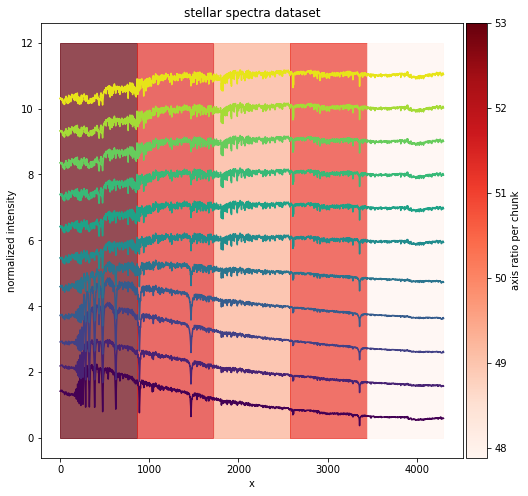

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


############################# plot the spectra #################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(1, figsize=(8, 8))
plt.title("stellar spectra dataset")
for i in range(0, len(spectra_list), 5):
    plt.plot(spectra_list[i] + i*0.2, color=m.to_rgba(i))
plt.xlabel("x")
plt.ylabel("normalized intensity")

########################### color-code each chunk according to the resulting axis ratio ###################
norm = mpl.colors.Normalize(vmin=numpy.min(axis_ratio_list), 
                            vmax=numpy.max(axis_ratio_list))
cmap = cm.Reds
m = cm.ScalarMappable(norm=norm, cmap=cmap)

x = numpy.arange(len(spectra_list[0]))
x_split = numpy.array_split(x, 5)

for i in range(5):
    x_min = x_split[i][0]
    x_max = x_split[i][-1]
    
    plt.fill_between([x_min, x_max], 0, 12, color=m.to_rgba(axis_ratio_list[i]), alpha=0.7)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm, label="axis ratio per chunk")

### What do we see?
We see that each of the chunks results in a different axis ratio, where the largest axis ratio is obtained for the first chunk, and the smallest axis ratio is obtained for the last chunk. Judging by the spectra themselves, it makes sense. The first part of the stellar spectra (until x of ~800) shows the strongest variation as a function of the sequence index, where the shape of the spectrum within the chunk shows a strong correlation with the sequence index. The last part of the stellar spectra (x larger than ~3500) is roughly constant, and shows only a weak variation as a function of the sequence index.<br>
Thus, we can see that larger axis ratios trace chunks where the sequence-related information is more significant. <br>

### scale=20

In [34]:
axis_ratio_list, sequence_list = seq.return_axis_ratios_and_sequences_per_chunk('L2', 20)
print("length of axis ratio list: ", len(axis_ratio_list))
print("axis ratios per chunk: ", axis_ratio_list)

length of axis ratio list:  20
axis ratios per chunk:  [49.62940548 53.         53.         53.         53.         53.
 53.         53.         53.         51.35243859 53.         51.16731933
 51.13029548 51.09327163 51.20434318 40.00320399 49.47632609 48.38341047
 42.82983268 45.80455678]


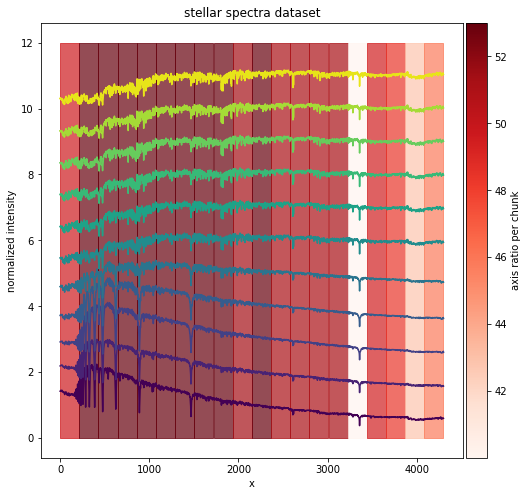

In [35]:
############################# plot the spectra #################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(1, figsize=(8, 8))
plt.title("stellar spectra dataset")
for i in range(0, len(spectra_list), 5):
    plt.plot(spectra_list[i] + i*0.2, color=m.to_rgba(i))
plt.xlabel("x")
plt.ylabel("normalized intensity")

########################### color-code each chunk according to the resulting axis ratio ###################
norm = mpl.colors.Normalize(vmin=numpy.min(axis_ratio_list), 
                            vmax=numpy.max(axis_ratio_list))
cmap = cm.Reds
m = cm.ScalarMappable(norm=norm, cmap=cmap)

x = numpy.arange(len(spectra_list[0]))
x_split = numpy.array_split(x, 20)

for i in range(20):
    x_min = x_split[i][0]
    x_max = x_split[i][-1]
    
    plt.fill_between([x_min, x_max], 0, 12, color=m.to_rgba(axis_ratio_list[i]), alpha=0.7)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm, label="axis ratio per chunk")

### What do we see?
Again, we can see that chunks that contain more sequence-related information result in a larger axis ratio. Regions where the spectral variation is tightly-correlated with the sequence index get larger axis ratios, and thus larger weights when constructing the average distance matrix per metric+scale. <br>

Therefore, the multi-scale approach of the Sequencer allows it to extract information from different chunks of the input data, focusing on regions that show more sequence-related information. 